# Toy Example

In [1]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch

### Autograd

In [225]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)

# with torch.no_grad():
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [226]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x000001FC899CC160>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001FC899CC160>


In [227]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1923, 0.2385, 0.2435],
        [0.1923, 0.2385, 0.2435],
        [0.1923, 0.2385, 0.2435],
        [0.1923, 0.2385, 0.2435],
        [0.1923, 0.2385, 0.2435]])
tensor([0.1923, 0.2385, 0.2435])


In [233]:
%%timeit
z = torch.matmul(x, w)+b

16.9 μs ± 122 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [234]:
%%timeit
with torch.no_grad():
    z = torch.matmul(x, w)+b

15.2 μs ± 104 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [236]:
%%timeit
z = torch.matmul(x, w)+b
z_det = z.detach()

20.3 μs ± 314 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [62]:
z = torch.matmul(x, w)+b
z_det = z.detach()

print(z.requires_grad, z.grad_fn)
print(z_det.requires_grad, z_det.grad_fn)

True <AddBackward0 object at 0x000001FC8992FD00>
False None


### Using autograd

array([0.01, 3.61])

tensor(5.4671, requires_grad=True)


100%|██████████| 100/100 [00:00<00:00, 3936.39it/s]


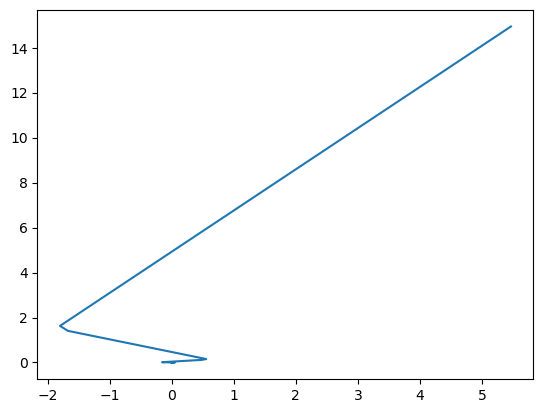

In [26]:
lr = 0.7
iters = 100
k = 2
rng = np.random.default_rng()

def expectation_a(as_):
    return as_.sum()/len(as_)

def expectation_a_square(as_):
    return np.square(as_).sum()/len(as_)

def var_a(as_):
    '''this is nothing but s^2'''
    return expectation_a_square(as_) - expectation_a(as_)**2

def func(x, as_, k = 2, stochastic=True):    
    if stochastic:
        a_ = rng.choice(as_, size=1)[0]
    else:
        a_ = expectation_a(as_)

    y = x*x*a_/k
    return y
    

x = torch.distributions.uniform.Uniform(-10, 10).sample()
x.requires_grad_(True)

print(x)

as_ = np.array([0.1, 1.9])
# as_ = np.array([1, 1])

x_prog = [x.item()]
f_prog = [func(x, as_, k = 2, stochastic=False).item()]

for _ in tqdm(range(iters)):
    y = func(x, as_, k = 2, stochastic=True)
    y.backward()

    with torch.no_grad():
        # print(x.grad == x*a_)
        x.copy_(x-lr*x.grad)
        x.grad.zero_()

    x_prog.append(x.item())
    f_prog.append(func(x, as_, k = 2, stochastic=False).item())


plt.plot(x_prog, f_prog)

In [ ]:
def calc_dynamic_value(a_, lr):
    return 1 - (2*lr*a_/k)
dynamics_rv = ([calc_dynamic_value(a_, lr) for a_ in as_])
dynamics_rv

[np.float64(0.93), np.float64(-0.32999999999999985)]